In [101]:
%%capture
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

In [102]:
import tensorflow as tf
from tensorflow import keras
import keras.utils

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.callbacks import ModelCheckpoint

import collections
import glob
import pandas as pd
import random
import numpy as np
from matplotlib import pyplot as plt

import fluidsynth
import pretty_midi
from IPython import display

from music21 import converter, instrument, note, chord, stream

In [103]:
print ("TF Version:", tf.__version__)
print ("Keras Version:", keras.__version__)

TF Version: 2.8.0
Keras Version: 2.8.0


In [105]:
from google.colab import drive
drive.mount("/content/gdrive/")

# location of general data folder
ALLDATA_DIR = "/content/gdrive/MyDrive/Github/sm-caltech-stem-machine-learning/data/"

# location of desired data folder
DATA_DIR = "/content/gdrive/MyDrive/Github/sm-caltech-stem-machine-learning/data/gamer/"

# location of weights folder
WEIGHTS_DIR = "/content/gdrive/MyDrive/Github/sm-caltech-stem-machine-learning/weights/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [106]:
def get_all_filepaths():
    fp = []
    for file in glob.glob(DATA_DIR + "*.mid"):
      fp.append(file);
    return fp


In [107]:
all_filepaths = get_all_filepaths()
print(f'# MIDI data file: {len(all_filepaths)}')

# MIDI data file: 50


In [108]:
# Sampling rate for audio playback
_SAMPLING_RATE = 16000

def random_midi(filepaths):
  rn = random.randint(0, len(filepaths)-1)
  return filepaths[rn];

def play_audio(midi_file):
  pm = pretty_midi.PrettyMIDI(midi_file) 
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  
  # Take a sample of the generated waveform to mitigate kernel resets
  return display.Audio(waveform, rate=_SAMPLING_RATE)
  

In [109]:
play_audio(random_midi(all_filepaths))

Output hidden; open in https://colab.research.google.com to view.

In [110]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    midi = converter.parse(midi_file)
    notes_to_parse = None
    notes = collections.defaultdict(list)

    # Check the amount of instrument
    score = instrument.partitionByInstrument(midi)
    if(score==None):
      return pd.DataFrame()

    if len(score.parts) == 1:
      notes_to_parse = midi.flat.notes
    else:
      notes_to_parse = score.parts[0].recurse()

    starting_offset = 0;
    for sound in notes_to_parse:
      if isinstance(sound, note.Note):
        # String of pitch name added to notes (ex 'F-2')
        notes['pitchName'].append(str(sound.pitch))
      elif isinstance(sound, chord.Chord):
        # Pitch ID of each note in chord, separated by period added to notes as string
        notes['pitchName'].append('.'.join(str(n) for n in sound.normalOrder))

      notes['quarterLength'].append(sound.duration.quarterLength)
      notes['offset'].append(sound.offset)
      notes['step'].append(sound.offset - starting_offset)
      starting_offset = sound.offset

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [111]:
sample_notes = midi_to_notes(random_midi(all_filepaths))
sample_notes.head(10)

,pitchName,quarterLength,offset,step
0,8.11,0.5,1.25,1.25
1,8.11,0.5,1.25,0.0
2,B3,0.5,1.5,0.25
3,B3,0.5,5/3,0.166667
4,6.9,0.5,2.0,0.333333
5,6.9,0.5,2.25,0.25
6,B3,0.5,2.5,0.25
7,B3,0.5,8/3,0.166667
8,4.8,0.5,3.0,0.333333
9,E5,1.0,3.0,0.0


In [112]:
def notes_to_midi(notes: pd.DataFrame, out_file: str = "test_output.mid" ):

  # Convert numbers predicted by the model back into music21 Note and Chord objects
  # return a list of Not and Chord objects
  cur_offset = 0
  output_notes = []

  for i, note_obj in notes.iterrows():
      # obj = chord
      if('.' in note_obj['pitchName']) or note_obj['pitchName'].isdigit():
          notes_in_chord = note_obj['pitchName'].split('.')
          n = []
          for cur_note in notes_in_chord:
              new_note = note.Note(int(cur_note))
              new_note.storedInstrument = instrument.Piano()
              n.append(new_note)
          new_chord = chord.Chord(n, 
                                 quarterLength = note_obj['quarterLength'])
          new_chord.offset = cur_offset + note_obj['step']
          output_notes.append(new_chord)

          cur_offset = new_chord.offset


      # obj = note
      else:
          new_note = note.Note(note_obj['pitchName'], 
                               quarterLength = note_obj['quarterLength'])
          new_note.offset = cur_offset + note_obj['step']
          new_note.storedInstrument = instrument.Piano()
          output_notes.append(new_note)

          cur_offset = new_note.offset

  midi_stream = stream.Stream(output_notes)
  midi_stream.write('midi', fp=out_file)
  return out_file
      

In [ ]:
play_audio(notes_to_midi(sample_notes))

Output hidden; open in https://colab.research.google.com to view.

In [113]:
num_files = 10
all_notes = []
for f in all_filepaths[:num_files]:
  df = midi_to_notes(f)
  if(df.empty):
    continue
  all_notes.append(df)

all_notes = pd.concat(all_notes)
n_notes = len(all_notes)

In [114]:
# all pitch names
pitchnames = sorted(set(n for n in all_notes['pitchName']))

n_vocab = len(pitchnames)

# dictionary to map pitches to integers
pitch_to_int = dict((note, number) for number, note in enumerate(pitchnames))

# converting pitchName to numbers
all_notes['pitchNum'] = [pitch_to_int[name] for name in all_notes['pitchName']]

In [115]:
# convert from float to float64 because for some reason making datasets and tensor slices require float32, or float 64
def convert_to_float64(df):
    for column in df:
      try:
        df[column] = np.asarray(df[column]).astype('float64')
      except ValueError:
        continue

In [116]:
convert_to_float64(all_notes)

all_features = ['pitchNum','quarterLength','step']
train_notes = np.stack([all_notes[feature] for feature in all_features], axis=1)

In [117]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [118]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    n_vocab: int
) -> tf.data.Dataset:

  # 1 extra for the label
  seq_length = seq_length+1

  # creating subsets of the dataset 
  windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)

  # flattens a dataset of datasets into a dataset of tensors
  sequences = windows.flat_map(lambda x : x.batch(seq_length, drop_remainder=True))

  def scale_pitch(x):
    x = x/[n_vocab, 1.0, 1.0]
    return x

  def split_labels(sequences):
    inputs = sequences[:-1]
    all_labels = sequences[-1]
    labels = {feature:all_labels[i] for i, feature in enumerate(all_features)}

    return scale_pitch(inputs), labels
  
  return sequences.map(split_labels, num_parallel_calls = tf.data.AUTOTUNE)


In [119]:
seq_length = 10
seq_ds = create_sequences(notes_ds, seq_length, n_vocab)
seq_ds.element_spec

(TensorSpec(shape=(10, 3), dtype=tf.float64, name=None),
 {'pitchNum': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'quarterLength': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [120]:
for seq, target in seq_ds.take(1):
  print('sequence shape: ', seq.shape)
  print('sequence elements (first 10): ', seq[0:10])
  print()
  print('target: ', target)

sequence shape:  (10, 3)
sequence elements (first 10):  tf.Tensor(
[[0.81122449 1.5        0.        ]
 [0.66836735 1.5        0.75      ]
 [0.89795918 1.5        0.75      ]
 [0.66836735 1.5        0.75      ]
 [0.81122449 1.5        0.75      ]
 [0.66836735 1.5        0.66666667]
 [0.89795918 1.5        0.83333333]
 [0.66836735 1.5        0.75      ]
 [0.81122449 1.5        0.75      ]
 [0.66836735 1.5        0.66666667]], shape=(10, 3), dtype=float64)

target:  {'pitchNum': <tf.Tensor: shape=(), dtype=float64, numpy=176.0>, 'quarterLength': <tf.Tensor: shape=(), dtype=float64, numpy=1.5>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.6666666666666666>}


In [121]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder = True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [122]:
train_ds.element_spec

(TensorSpec(shape=(64, 10, 3), dtype=tf.float64, name=None),
 {'pitchNum': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'quarterLength': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [123]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [138]:
# Model Building (not using sequential() because it's no bueno with multiple outputs/inputs)
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)

x = tf.keras.layers.LSTM(516, return_sequences = True)(inputs)                   

x = tf.keras.layers.LSTM(516, return_sequences = True)(x)   
x = tf.keras.layers.LSTM(516, return_sequences = True)(x)                                                                                             
x = tf.keras.layers.LSTM(516)(x)                                                 
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dense(300)(x)

outputs = {
    'pitchNum': tf.keras.layers.Dense(n_vocab, name='pitchNum')(x),
    'quarterLength': tf.keras.layers.Dense(1, name='quarterLength')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
    'pitchNum': tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    'quarterLength': mse_with_positive_pressure,
    'step': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model.compile(loss = loss, optimizer = optimizer)

model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 10, 3)]      0           []                               
                                                                                                  
 lstm_21 (LSTM)                 (None, 10, 516)      1073280     ['input_9[0][0]']                
                                                                                                  
 lstm_22 (LSTM)                 (None, 10, 516)      2132112     ['lstm_21[0][0]']                
                                                                                                  
 lstm_23 (LSTM)                 (None, 10, 516)      2132112     ['lstm_22[0][0]']                
                                                                                            

In [139]:
model.compile(
    loss=loss,
    loss_weights={
        'pitchNum': 1,
        'quarterLength': 1,
        'step': 1
    },
    optimizer=optimizer
)

In [127]:
losses = model.evaluate(train_ds, return_dict = True)
losses

83/83 [==============================] - 9s 19ms/step - loss: 7.2890 - pitchNum_loss: 5.2777 - quarterLength_loss: 1.5269 - step_loss: 0.4844


{'loss': 7.288989543914795,
 'pitchNum_loss': 5.277660369873047,
 'quarterLength_loss': 1.5268957614898682,
 'step_loss': 0.48443466424942017}

In [128]:
filepath = "Epoch {epoch:02d} - Loss {loss:.4f}.hdf5"

checkpoint = ModelCheckpoint(                                         # checkpoint allows us to save the weights to a file after every epoch or when every training steps
    filepath, monitor = 'loss',
    verbose = 0,
    save_best_only = True,
    mode='min'
)

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystopping]

In [140]:
history = model.fit(train_ds, epochs=100, callbacks=callbacks_list)

Epoch 1/100
83/83 [==============================] - 11s 47ms/step - loss: 8.3887 - pitchNum_loss: 4.7438 - quarterLength_loss: 1.8218 - step_loss: 1.8231
Epoch 2/100
83/83 [==============================] - 4s 45ms/step - loss: 5.3998 - pitchNum_loss: 4.4195 - quarterLength_loss: 0.7905 - step_loss: 0.1897
Epoch 3/100
83/83 [==============================] - 4s 46ms/step - loss: 5.2736 - pitchNum_loss: 4.3084 - quarterLength_loss: 0.7839 - step_loss: 0.1814
Epoch 4/100
83/83 [==============================] - 4s 46ms/step - loss: 5.1965 - pitchNum_loss: 4.2479 - quarterLength_loss: 0.7760 - step_loss: 0.1726
Epoch 5/100
83/83 [==============================] - 4s 46ms/step - loss: 5.1394 - pitchNum_loss: 4.2028 - quarterLength_loss: 0.7708 - step_loss: 0.1658
Epoch 6/100
83/83 [==============================] - 4s 45ms/step - loss: 5.0827 - pitchNum_loss: 4.1550 - quarterLength_loss: 0.7645 - step_loss: 0.1632
Epoch 7/100
83/83 [==============================] - 4s 45ms/step - loss: 5

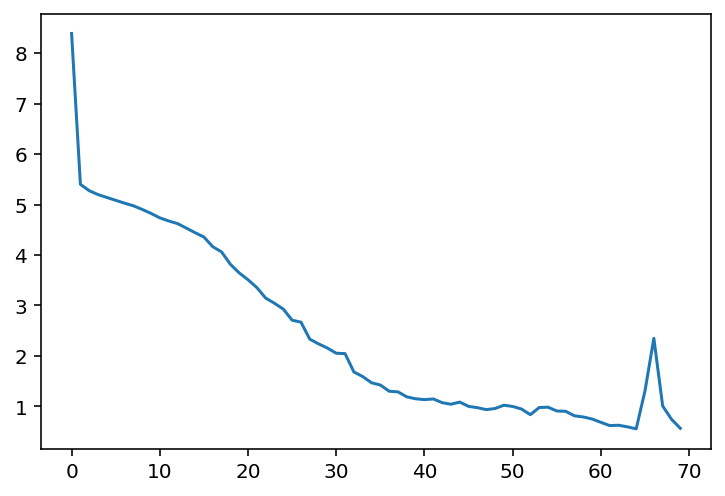

In [141]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
# Loading weights
model.load_weights(WEIGHTS_DIR + "maestro_0.0744.hdf5")
model.load_weights()

ValueError: ignored

In [131]:
# Predicting and Generating
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0):
  
  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitchNum']
  step = predictions['step']
  quarterLength = predictions['quarterLength']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  quarterLength = tf.squeeze(quarterLength, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # step and quarterLength values should be non-negative
  step = tf.maximum(0, step)
  quarterLength = tf.maximum(0, quarterLength)

  return int(pitch), float(quarterLength), float(step)


In [132]:
def generate_notes(num_notes: int = 100, temperature = 1.0) -> pd.DataFrame:

  # getting initial sequence of notes
  init_start = np.random.randint(0, train_notes.shape[0]-seq_length)
  note_seq = (train_notes[init_start:init_start+seq_length] / np.array([n_vocab, 1, 1]))

  int_to_pitch = dict((num, note) for num, note in enumerate(pitchnames))
  generated_notes = []
  prev_offset = 0
  for _ in range(num_notes):
    pitchNum, quarterLength, step = predict_next_note(note_seq, model, temperature)
    offset = prev_offset + step
    pitchName = int_to_pitch[pitchNum]
    note = (pitchNum, quarterLength, step)
    generated_notes.append((*note, offset, pitchName))
    
    note_seq = np.delete(note_seq, 0, axis = 0)
    note_seq = np.append(note_seq, np.expand_dims(note, 0), axis=0)

    prev_offset = offset

  generated_notes = pd.DataFrame(generated_notes, columns=(*all_features, 'offset', 'pitchName'))
  return generated_notes
    
    

In [137]:
#@title Generate Music 

numNotes = 100#@param {type:"integer"}

output_notes = generate_notes(numNotes, 1.0)
play_audio(notes_to_midi(output_notes))